In [96]:
%run ../demos/qsu.ipynb  # color-printing functions
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import INIDErrorModel
from qecsim.models.rotatedplanar import RotatedPlanarCode, RotatedPlanarReweightedMWPMDecoder

import pandas as pd
from pathlib import Path

In [97]:
# Load the T_1 and T_2 times from the IBM calibration data
p = Path(Path.cwd(), "ibm_sherbrooke_calibrations_2024-03-11.csv")
df = pd.read_csv(p)
df_new = df[df["T2 (us)"] <= 2* df["T1 (us)"]]
T_1 = df_new["T1 (us)"].values * 1e-6 # Convert to seconds
T_2 = df_new["T2 (us)"].values * 1e-6

print("number of qubits:", len(T_1))

number of qubits: 125


In [98]:
# initialise Rotated Planar Code, INID error model
my_code = RotatedPlanarCode(7, 7)
# if there are more T_1 and T_2 times than number of qubits n in the code, the first n T_1 and T_2 times are used
my_error_model = INIDErrorModel(T_1, T_2)
# print models
print(my_code)
print(my_error_model)

RotatedPlanarCode(7, 7)
INIDErrorModel()


In [99]:
def create_decoders(code, t, num_decoders, rng):
    decoders = []
    for _ in range(num_decoders):
        #create random T_1 and T_2 between 10ms and 400ms to reweight each decoder
        T_1 = rng.uniform(10e-6, 400e-6, size=code.n_k_d[0])
        T_2 = rng.uniform(10e-6, 400e-6, size=code.n_k_d[0])
        decoders.append(RotatedPlanarReweightedMWPMDecoder(code, t, T_1, T_2))
        
    return decoders

In [106]:
from qecsim import app
from qecsim.model import DecodeResult
from collections import Counter, defaultdict
# set random seed for reproducibility
rng = np.random.default_rng(16)

NUM_ERRORS = 10000
NUM_DECODERS = 10
t = 0.00002

# sample from the error model
errors = [my_error_model.generate(my_code,t , rng) for _ in range(NUM_ERRORS)]

# qsu.print_pauli(my_code.new_pauli(error[0]))
decoders = create_decoders(my_code, t, NUM_DECODERS, rng)

decoders.append(RotatedPlanarReweightedMWPMDecoder(my_code, t, T_1, T_2))



In [290]:
import pandas as pd
data = []
for e, error in enumerate(errors):
    syndrome = pt.bsp(error, my_code.stabilizers.T)
    for d, decoder in enumerate(decoders):
        recovery = decoder.decode(my_code, syndrome)
        recovery_str = pt.bsf_to_pauli(recovery)
        success = not (any(pt.bsp(recovery ^ error, my_code.stabilizers.T)) or any(pt.bsp(recovery ^ error, my_code.logicals.T)))  
        data.append({'error': e, 'recovery_str': recovery_str, 'decoder': d, 'success': success})
df = pd.DataFrame(data)
df.head()

In [491]:
# for each error get the majority vote
majority = []
for e in range(NUM_ERRORS):
    recovery_str = df[df.error == e].recovery_str.tolist()
    #shuffle the recovery strings for the case that two recovery strings have the same count the majority recovery is chosen randomly
    # np.random.shuffle(recovery_str)
    #get the most common recovery string and how many decoder agreed on it
    recovery_counts = Counter(recovery_str)
    majority_recovery, majority_count = recovery_counts.most_common(1)[0]
    # check if the majority recovery is successful
    # success = df[(df.error == e) & (df.recovery_str == majority_recovery)].success.values[0]
    success = not (any(pt.bsp(pt.pauli_to_bsf(majority_recovery) ^ (errors[e]), my_code.stabilizers.T)) or any(pt.bsp(pt.pauli_to_bsf(majority_recovery) ^ (errors[e]), my_code.logicals.T)))
    # check if the majority count is the majority
    is_majority = majority_count > (len(decoders) / 2)
    majority.append({'error': e, 'majority_recovery': majority_recovery, 'majority_count': majority_count, 'success_of_majority': success, 'is_majority': is_majority})

df_majority = pd.DataFrame(majority)
df_majority.head()

,error,majority_recovery,majority_count,success_of_majority,is_majority
0,0,IIIIIIIIIIIIIIZZIIIIZIIIIIIIZZIIIIIIIIZIIIIIIIIII,8,True,True
1,1,ZIIIIIIIIIIIIIIIZIIIIIIIIIIXIIIIIIIZIIIIIIIIIIZII,5,True,False
2,2,IIIIIIIIIIIIIIIZIIIIIIXIIIIYIIZIIXIIZIIIIIIIIIIII,3,True,False
3,3,IIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII,11,True,True
4,4,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIYZIIIIIIIII,7,True,True


In [492]:
# for each decoder count the number of times it agrees with the majority
agreement_without_failure = []
agreement_with_failure = []
for e in range(NUM_ERRORS):
    decoders_that_agree = (df[df.error == e].recovery_str == df_majority.majority_recovery[e]).to_list()
    agree = np.arange(len(decoders_that_agree))[decoders_that_agree].tolist()
    if df_majority.success_of_majority[e] and df_majority.is_majority[e]:
        agreement_without_failure += agree
    agreement_with_failure += agree

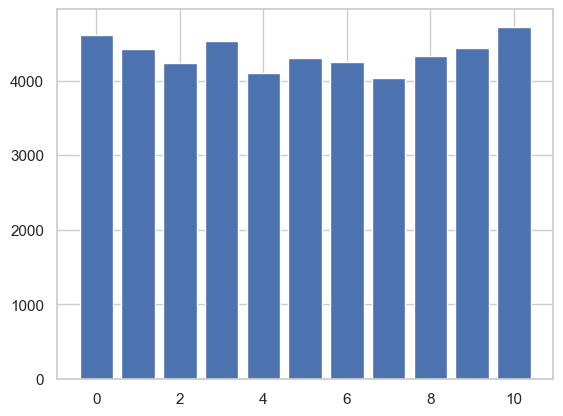

In [493]:
import matplotlib.pyplot as plt
n, bins, _=plt.hist(agreement_without_failure, bins= np.arange(NUM_DECODERS + 2) - 0.5, rwidth=0.8, align = 'mid', label = 'without failure')

<Axes: xlabel='decoder', ylabel='Count'>

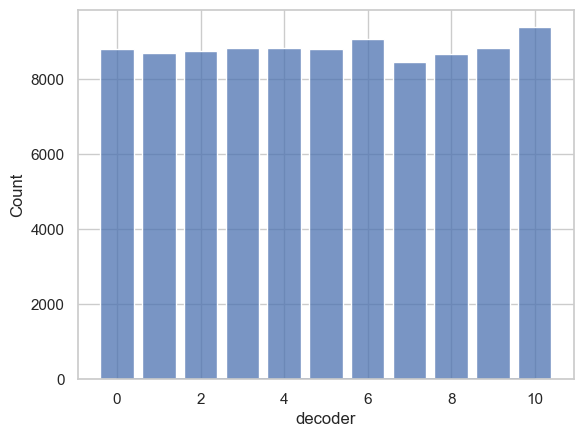

In [494]:
sns.histplot(data=df[df["success"]==True], x="decoder", multiple="dodge", shrink=0.8, discrete=True)
# for each error count the number of different recovery strings

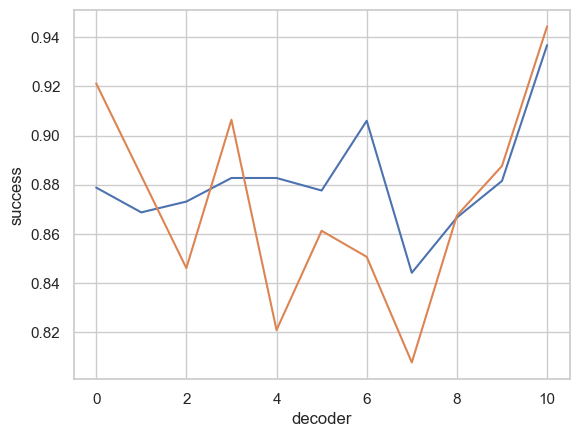

In [502]:

# for each error count the number of different recovery strings
sns.lineplot(df.groupby('decoder')['success'].mean())
plt.plot(n*2/NUM_ERRORS, label = 'without failure')

In [105]:
# recovery_counts = []
# for error in errors:
#     syndrome = pt.bsp(error, my_code.stabilizers.T)
#     different_recoveries = {}
#     for d, decoder in enumerate(decoders):
#         recovery = decoder.decode(my_code, syndrome)
#         recovery_str = pt.bsf_to_pauli(recovery)
#         if recovery_str not in different_recoveries:
#             success = not (any(pt.bsp(recovery ^ error, my_code.stabilizers.T)) or any(pt.bsp(recovery ^ error, my_code.logicals.T)))
#             different_recoveries[recovery_str] = {"count": 1, "decoders": [d], "success": success}
#         else:
#             different_recoveries[recovery_str]["count"] += 1
#             different_recoveries[recovery_str]["decoders"].append(d)
#     recovery_counts.append(different_recoveries)

# print recovery_counts
# for i, recovery_res in enumerate(recovery_counts):
#     print(f"Error {i}")
#     for recovery, data in recovery_res.items():
#         print(f"Recovery: {recovery}, count: {data['count']}, success: {data['success']}, decoders: {data['decoders']}")

# import matplotlib.pyplot as plt
# decoder_count = []
# # for each error find the recovery that the most decoders agree on
# for i, error in enumerate(recovery_counts):
#     for recovery in error:
#         if error[recovery]["count"] == max(error.values(), key=lambda x: x["count"])["count"]:
#             decoder_count.append(len(error[recovery]["decoders"]))
#             break

# plt.hist(decoder_count, bins=np.arange(NUM_DECODERS+1)-0.5, rwidth=0.7, align="mid")
# plt.show()